In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

C:\Users\sigi2\anaconda3\envs\DataScience\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Reading the flatfile dataset and showing 5 top rows:

In [2]:
df = pd.read_csv('final_df.csv', index_col=[0])
df.head()

,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_tagline,keyword_cnt,release_year,...,num_of_cast,num_of_male_cast,num_of_female_cast,num_of_crew,num_of_male_crew,num_of_female_crew,num_of_production_countries,has_top_keyword_3d,has_top_keyword_superhero,has_top_keyword_basedonnovel
0,14000000.0,en,6.575393,2/20/2015,93.0,Short,12314651.0,1.0,4.0,2015.0,...,24.0,10.0,8.0,72.0,13.0,0.0,1.0,0.0,0.0,0.0
1,40000000.0,en,8.248895,8/6/2004,113.0,Medium,95149435.0,1.0,4.0,2004.0,...,20.0,10.0,10.0,9.0,4.0,4.0,1.0,0.0,0.0,0.0
2,3300000.0,en,64.299990,10/10/2014,105.0,Medium,13092000.0,1.0,12.0,2014.0,...,51.0,13.0,7.0,64.0,11.0,4.0,1.0,0.0,0.0,0.0
3,1200000.0,hi,3.174936,3/9/2012,122.0,Large,16000000.0,0.0,7.0,2012.0,...,7.0,2.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,ko,1.148070,2/5/2009,118.0,Medium,3923970.0,0.0,0.0,2009.0,...,4.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
df['release_date'] = pd.to_datetime(df['release_date'])

Columns information: missing value counts and column types:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 87 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   budget                                                  3000 non-null   float64       
 1   original_language                                       3000 non-null   object        
 2   popularity                                              3000 non-null   float64       
 3   release_date                                            3000 non-null   datetime64[ns]
 4   runtime                                                 3000 non-null   float64       
 5   runtime_cat                                             3000 non-null   object        
 6   revenue                                                 3000 non-null   float64       
 7   sw_tagline                                              3000

Keeping only letters and underscore in column names:

In [6]:
df.columns = df.columns.str.replace('(\([A-Z]*)\)', '')
df.columns = df.columns.str.replace('-', '_')
df.columns = df.columns.str.replace('.', '')
df.columns = df.columns.str.replace(' ', '')

Creating seperated dataframes for numerical, dummy and categorical features for a more convenient statistical analysis:

In [7]:
df_dummy = df[[col for col in df if np.isin(df[col].dropna().unique(), [0, 1]).all()]]
for col in df:
    if col in df_dummy.columns:
        df[col] = df[col].astype('object')
        
df_categorical = df.select_dtypes(include=[np.object, np.datetime64]).drop(columns=df_dummy.columns).join(df['revenue'])
df_dummy = df_dummy.astype('float64').join(df['revenue'])
df_num = df.select_dtypes(include = ['float64', 'int64'])

# Descriptive Statistics

In [8]:
# import sweetviz as sv
# #analyzing the dataset
# df_report = sv.analyze(df)
# #display the report
# df_report.show_html('df.html')

In [9]:
df_num.iloc[:,:20].describe()

,budget,popularity,runtime,revenue,keyword_cnt,release_year,release_month,release_day,countries_cnt,actor0_movies_cnt,actor0_movies_3y_cnt,actor1_movies_cnt,actor1_movies_3y_cnt,actor2_movies_cnt,actor2_movies_3y_cnt,director_movies_cnt,director_movies_3y_cnt,depart_Art,depart_Camera,depart_Crew
count,3.000000e+03,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.00000,3000.000000,3000.000000
mean,2.253133e+07,8.463274,107.849333,6.672585e+07,7.226667,1999.713000,6.775333,15.046333,1.326333,3.513667,0.832667,2.636333,0.673333,2.364000,0.619000,0.77100,0.149333,2.71600,1.827667,2.470667
std,3.702609e+07,12.104000,22.082675,1.375323e+08,6.665891,15.423313,3.409115,8.632981,0.752349,4.309989,1.121793,3.685368,1.004469,3.461334,0.981577,1.34083,0.381770,4.05259,2.570377,6.149017
min,0.000000e+00,0.000001,0.000000,1.000000e+00,0.000000,1921.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,0.000000e+00,4.018053,94.000000,2.379808e+06,3.000000,1993.000000,4.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
50%,8.000000e+06,7.374861,104.000000,1.680707e+07,6.000000,2004.000000,7.000000,15.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.00000,1.000000,0.000000
75%,2.900000e+07,10.890983,118.000000,6.891920e+07,10.000000,2011.000000,10.000000,22.000000,1.000000,5.000000,1.000000,4.000000,1.000000,3.000000,1.000000,1.00000,0.000000,3.00000,2.000000,2.000000
max,3.800000e+08,294.337037,338.000000,1.519558e+09,149.000000,2017.000000,12.000000,31.000000,8.000000,28.000000,7.000000,29.000000,6.000000,29.000000,9.000000,10.00000,2.000000,28.00000,23.000000,119.000000


In [10]:
df_num.iloc[:,20:-1].describe()

,depart_Directing,depart_Editing,depart_Production,depart_Sound,depart_Writing,director_5y_cnt,directors_5y_revenue,overview_len,tagline_len,num_genres,num_of_cast,num_of_male_cast,num_of_female_cast,num_of_crew,num_of_male_crew,num_of_female_crew
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1.663333,1.523333,5.339667,3.151333,2.200667,0.273000,2.910434e+07,307.805667,35.761000,2.508000,20.770333,9.398667,4.542667,24.638000,8.365667,2.159333
std,1.352010,1.752659,5.269492,4.595883,1.593920,0.551276,1.192104e+08,167.023568,29.041069,1.111312,16.555128,7.353939,4.704702,28.204423,6.777408,2.709439
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,178.000000,17.000000,2.000000,11.000000,5.000000,2.000000,8.000000,3.000000,0.000000
50%,1.000000,1.000000,4.000000,1.000000,2.000000,0.000000,0.000000e+00,285.000000,32.000000,2.000000,16.000000,8.000000,3.000000,15.000000,7.000000,1.000000
75%,2.000000,2.000000,8.000000,3.000000,3.000000,0.000000,0.000000e+00,395.250000,50.000000,3.000000,24.000000,12.000000,6.000000,29.000000,11.000000,3.000000
max,30.000000,14.000000,34.000000,31.000000,20.000000,4.000000,1.960044e+09,1007.000000,232.000000,7.000000,156.000000,84.000000,87.000000,194.000000,91.000000,30.000000


In [11]:
df_dummy.iloc[:,:20].describe()

,sw_tagline,high_release_month,lang_US,lang_FR,lang_RU,lang_ES,lang_JA,sw_female_actor0,sw_female_actor1,sw_female_actor2,sw_male_actor1,sw_male_actor2,genre_adventure,genre_fantasy,genre_drama,genre_horror,genre_action,genre_comedy,genre_thriller,genre_crime
count,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.801000,0.396000,0.872667,0.09600,0.050667,0.079667,0.029667,0.237333,0.371000,0.331667,0.523667,0.544333,0.146333,0.077333,0.512667,0.100333,0.247000,0.343000,0.263000,0.156333
std,0.399315,0.489146,0.333402,0.29464,0.219353,0.270822,0.169694,0.425519,0.483153,0.470890,0.499523,0.498114,0.353499,0.267164,0.499923,0.300494,0.431339,0.474791,0.440336,0.363232
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df_dummy.iloc[:,20:-1].describe()

,genre_science_fiction,genre_mystery,genre_romance,genre_family,isProductionCompany_WarnerBros,isProductionCompany_UniversalPictures,isProductionCompany_ParamountPictures,isProductionCompany_TwentiethCenturyFoxFilmCorporation,isProductionCountry_US,isProductionCountry_GB,isProductionCountry_FR,isProductionCountry_DE,isProductionCountry_CA,has_top_keyword_3d,has_top_keyword_superhero,has_top_keyword_basedonnovel
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.097000,0.075000,0.191000,0.086667,0.060333,0.056333,0.045333,0.040000,0.760667,0.126667,0.074000,0.055667,0.040000,0.013333,0.010667,0.037000
std,0.296007,0.263435,0.393155,0.281393,0.238143,0.230603,0.208069,0.195992,0.426748,0.332655,0.261815,0.229315,0.195992,0.114717,0.102744,0.188793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Dummy variables are valid - all min and max values are 0 and 1, meaning that column values contains only 0 and 1.

# Data Distribution

General overview of every feature's distribution:

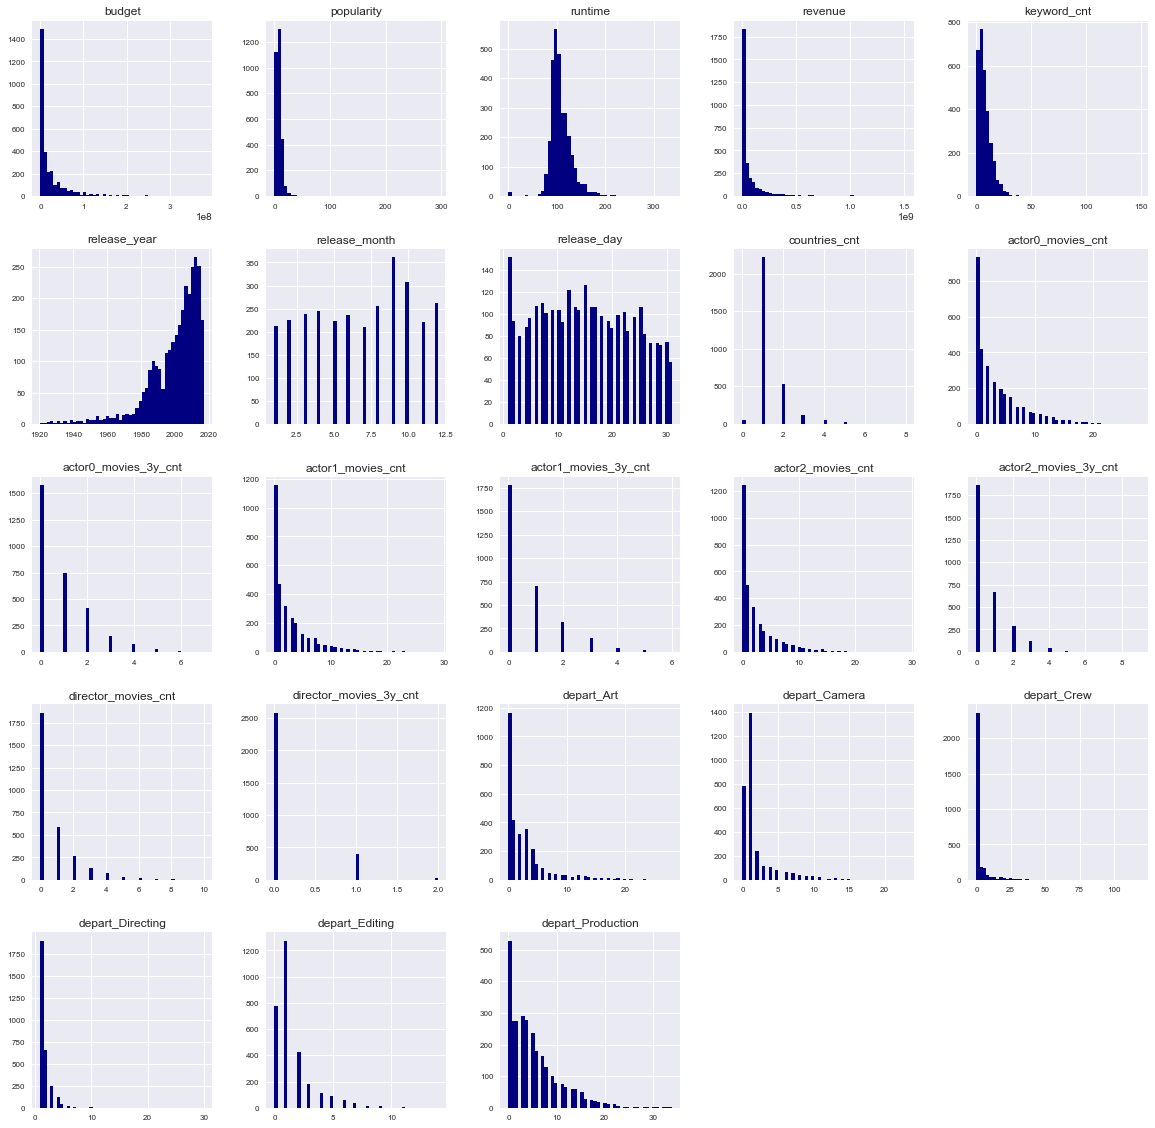

In [13]:
df_num.iloc[:,:23].hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8, color = "navy");

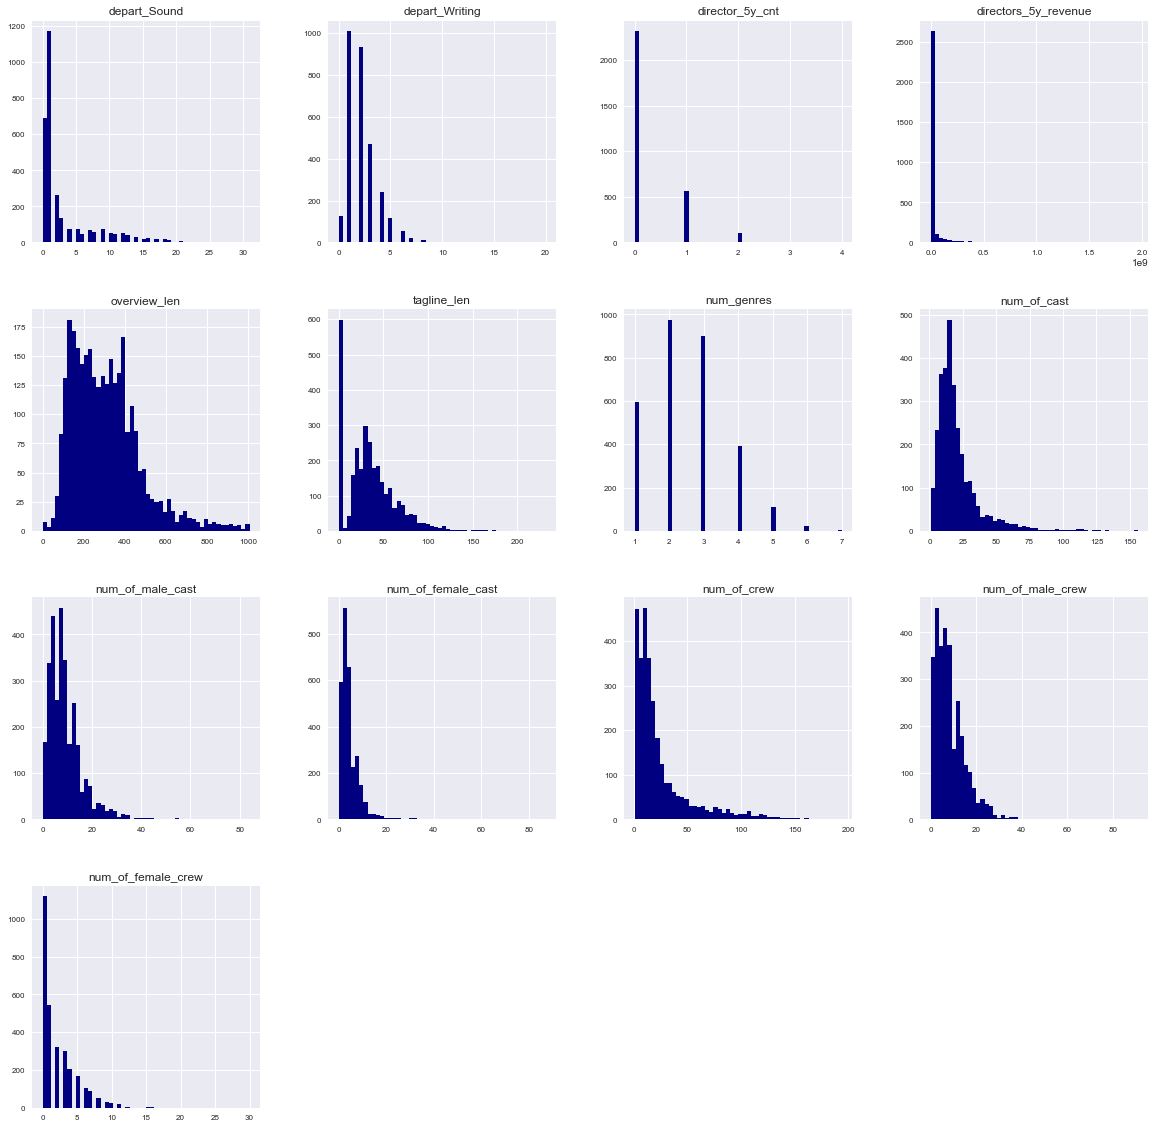

In [14]:
df_num.iloc[:,23:-1].hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8, color = "navy");

We can see that data is skewed, let's measure the asymmetry of the probability distribution:

In [15]:
def highlight(cell_value):
    highlight = 'background-color: cyan;'
    default = ''
    if cell_value > 1:
        return highlight
    else:
        return default  
pd.DataFrame(df_num.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

,skewness
popularity,14.377407
directors_5y_revenue,8.197778
depart_Directing,7.029450
num_of_production_countries,6.306434
depart_Crew,5.774022
keyword_cnt,4.927144
num_of_female_cast,4.725949
revenue,4.542285
budget,3.103530
num_of_cast,2.655293


Most of the data is highly skewed (skewness > 1), later we'll see if outliers or missing values can affect the features distribution.

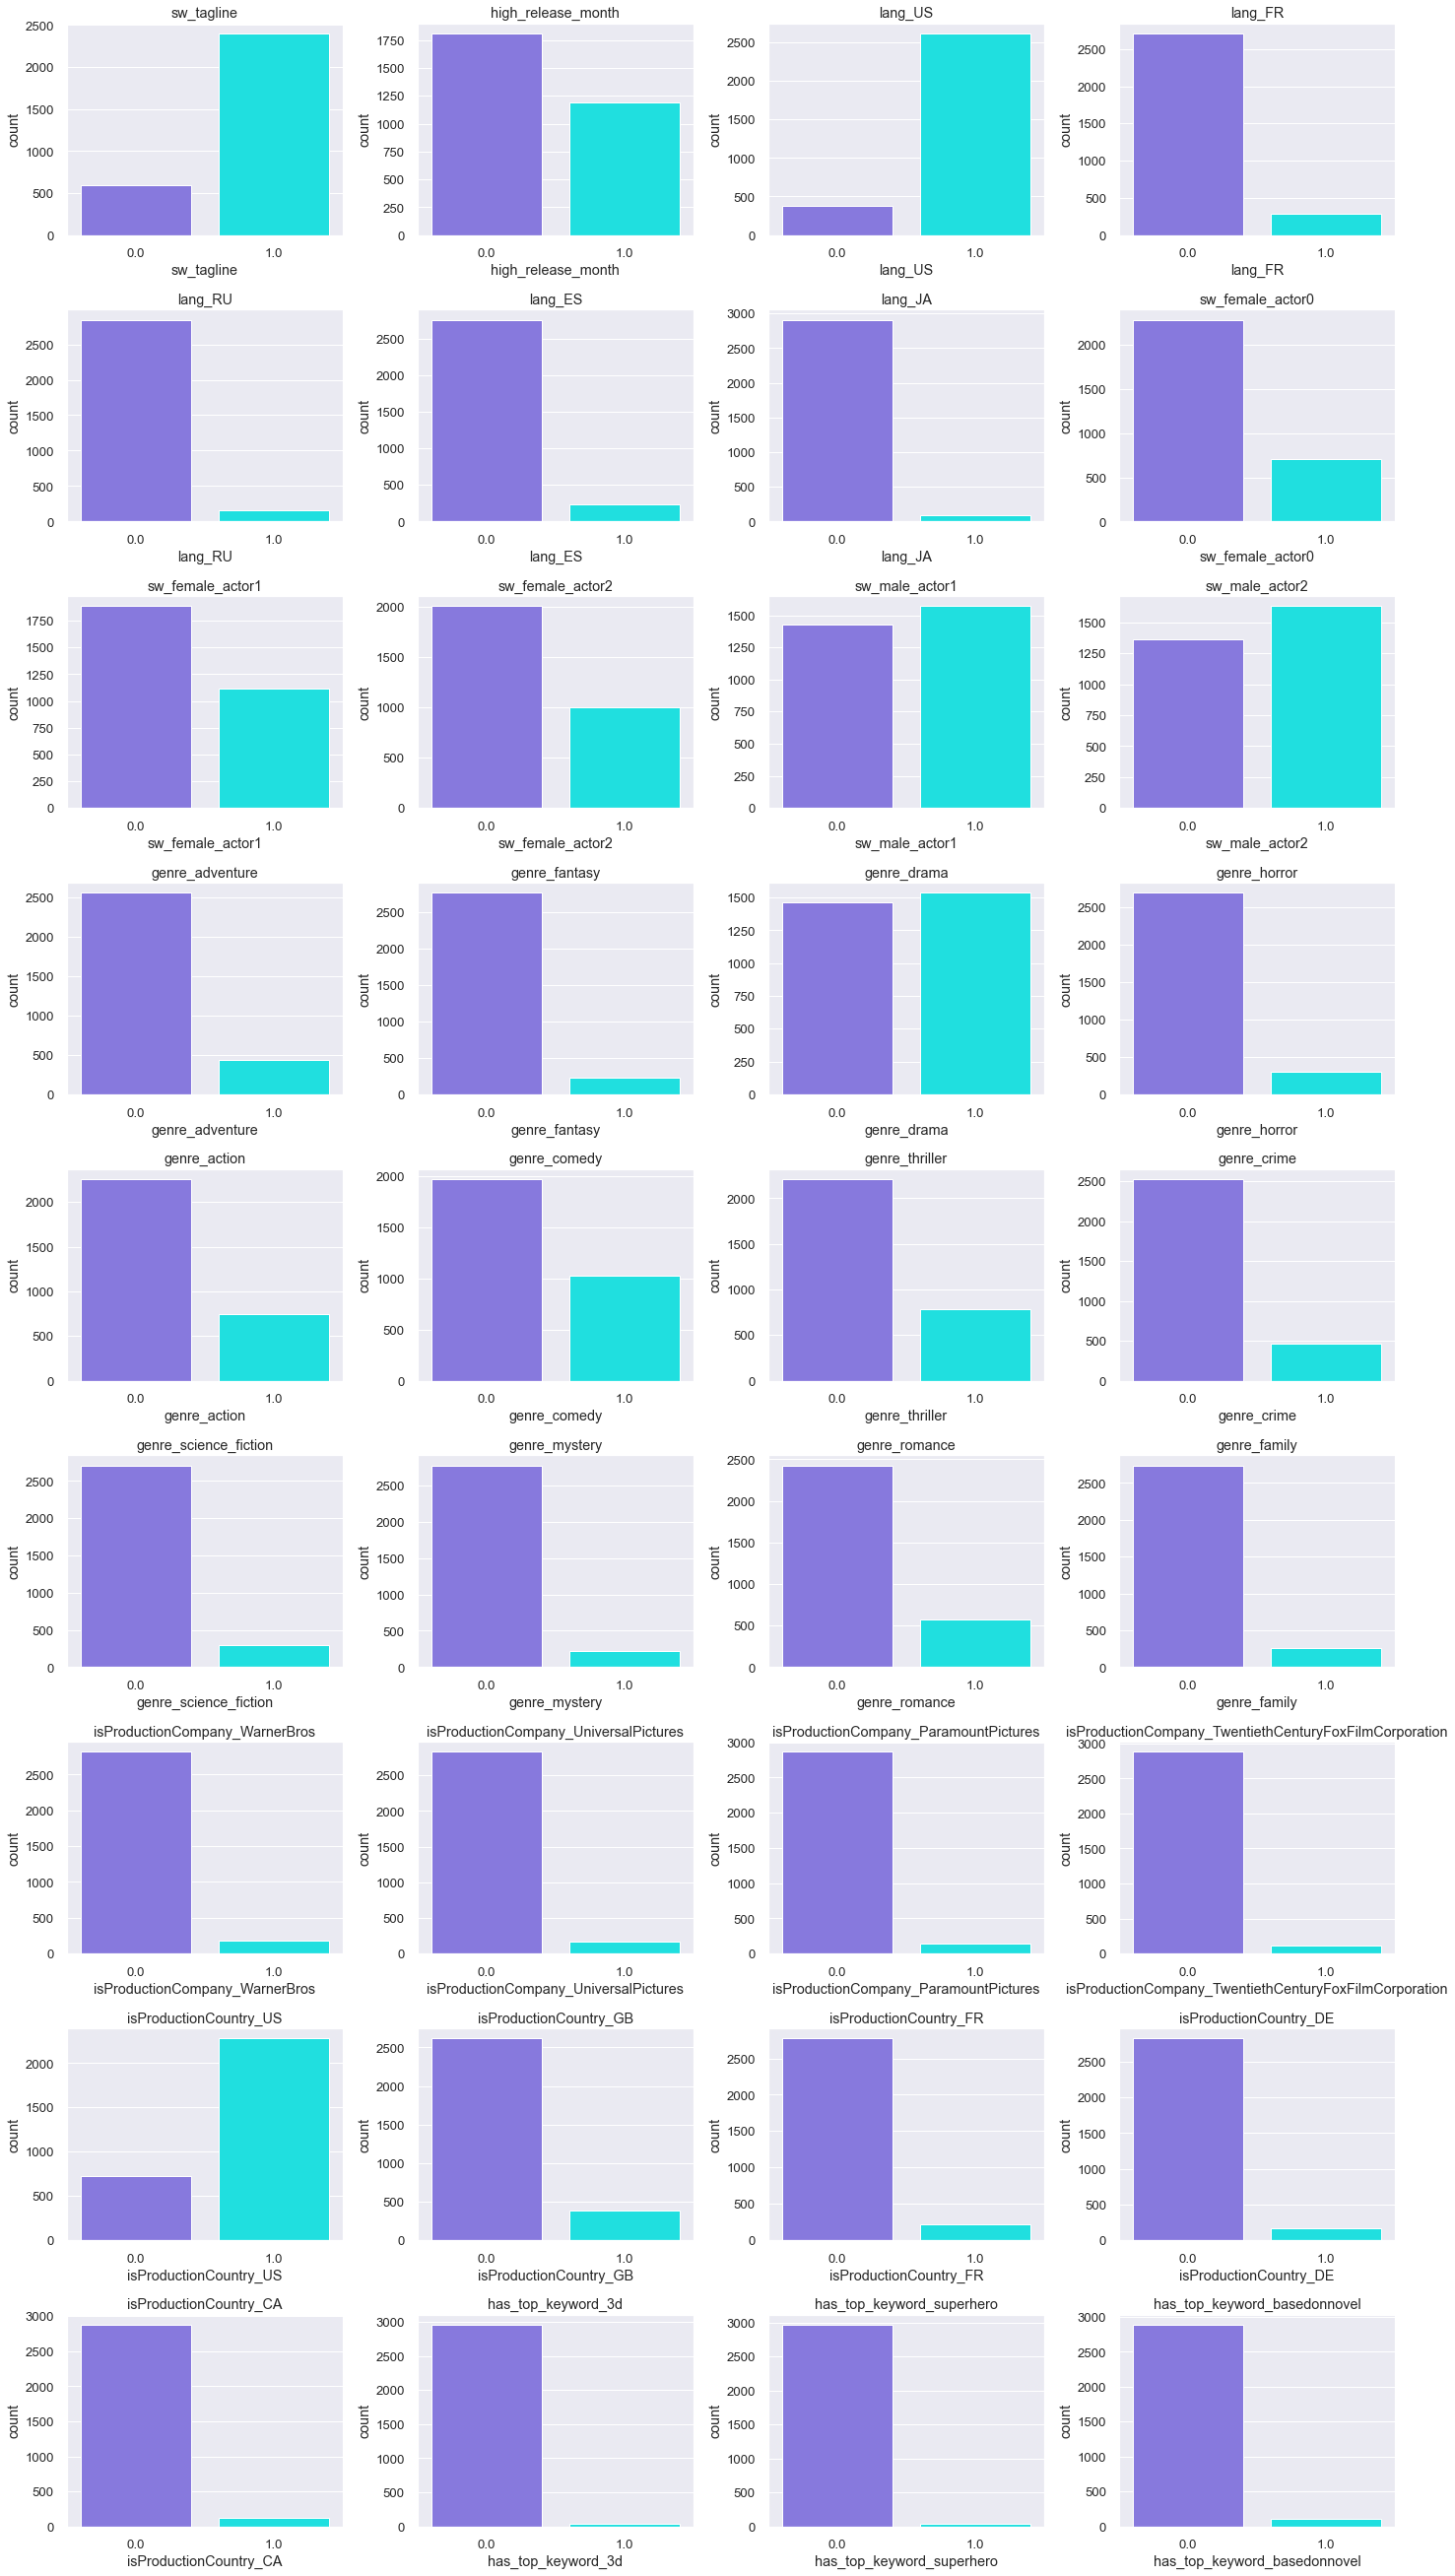

In [16]:
a = 10  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(20,40))
plt.subplots_adjust(hspace = 0.5)
sns.set(font_scale = 1.2)
for i in df_dummy:
    if i != 'revenue':
        plt.subplot(a, b, c)
        plt.title('{}'.format(i))
        plt.xlabel(i)
        sns.countplot(df_dummy[i], palette=['mediumslateblue','cyan'])
        c = c + 1
fig.tight_layout()
plt.show()

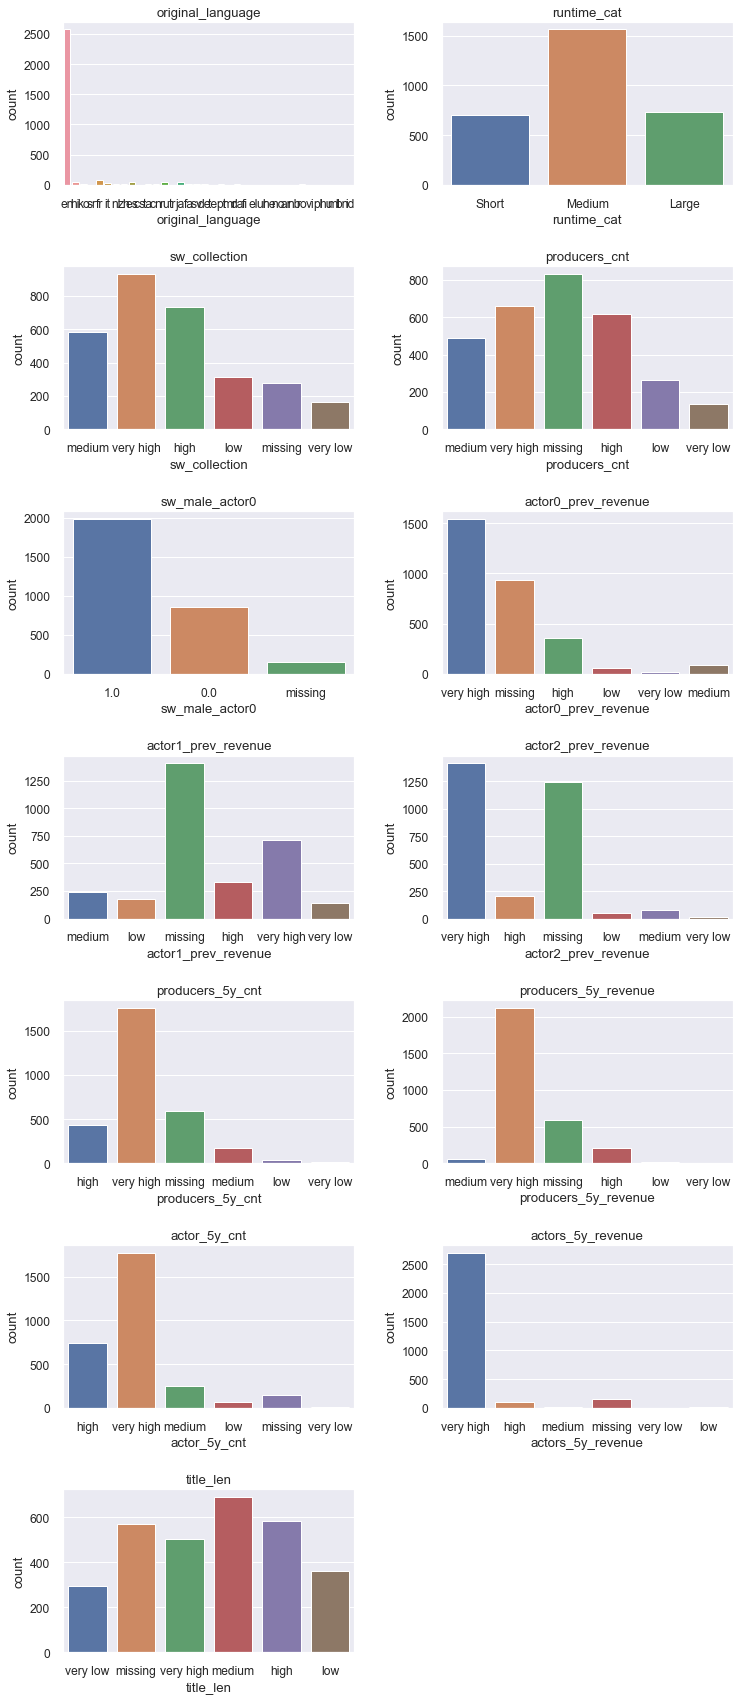

In [17]:
c = 1  # initialize plot counter

fig = plt.figure(figsize=(12,30))
sns.set(font_scale = 1.1)
for i in df_categorical:
    if i != 'revenue' and i != 'release_date':
        plt.subplot(7, 2, c)
        plt.title('{}'.format(i))
        plt.xlabel(i)
        sns.countplot(df_categorical[i])
        c = c + 1
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
plt.show()

#### Distribution of the target variable - Revenue:

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64


Text(0.5, 1.0, 'Log1p transformed Revenue Histogram')

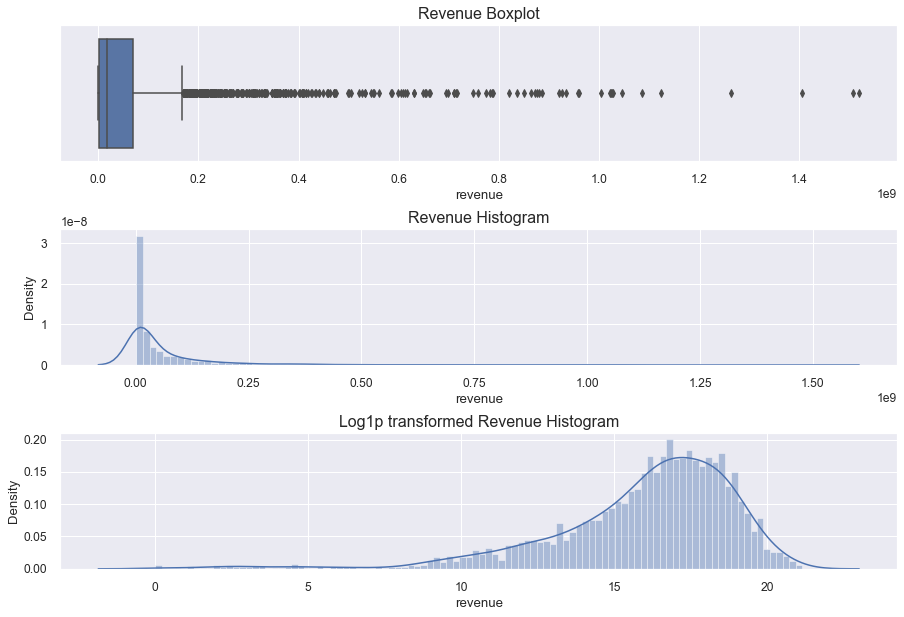

In [18]:
print(df['revenue'].describe())
f, ax = plt.subplots(3, figsize=(15,10))
plt.subplots_adjust(hspace = 0.5)

a = sns.boxplot(x=df.revenue, ax = ax[0])
a.axes.set_title("Revenue Boxplot",fontsize=16)

b = sns.distplot(a=df.revenue, color='b', bins=100, hist_kws={'alpha': 0.4}, ax = ax[1])
b.axes.set_title("Revenue Histogram",fontsize=16)

c = sns.distplot(a=np.log(df.revenue), color='b', bins=100, hist_kws={'alpha': 0.4}, ax = ax[2])
c.axes.set_title("Log1p transformed Revenue Histogram",fontsize=16)

# Correlations

In [19]:
corr = df.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

,budget,popularity,runtime,revenue,keyword_cnt,release_year,release_month,release_day,countries_cnt,actor0_movies_cnt,actor0_movies_3y_cnt,actor1_movies_cnt,actor1_movies_3y_cnt,actor2_movies_cnt,actor2_movies_3y_cnt,director_movies_cnt,director_movies_3y_cnt,depart_Art,depart_Camera,depart_Crew,depart_Directing,depart_Editing,depart_Production,depart_Sound,depart_Writing,director_5y_cnt,directors_5y_revenue,overview_len,tagline_len,num_genres,num_of_cast,num_of_male_cast,num_of_female_cast,num_of_crew,num_of_male_crew,num_of_female_crew,num_of_production_countries
budget,1.0000,0.5096,0.2622,0.6912,0.2652,0.1542,0.0523,0.0185,0.1538,0.4021,0.2873,0.4005,0.3097,0.3575,0.2806,0.3485,0.1556,0.4018,0.3353,0.3349,0.2740,0.3779,0.4097,0.3637,0.2708,0.2280,0.2589,-0.0018,0.1245,0.2536,0.3874,0.4815,0.3105,0.4483,0.5285,0.4280,0.0749
popularity,0.5096,1.0000,0.1845,0.5962,0.4266,0.1304,0.0243,0.0396,0.1732,0.3157,0.2272,0.2969,0.2329,0.2842,0.2316,0.2612,0.1137,0.4249,0.4099,0.3403,0.2968,0.4439,0.4591,0.4359,0.2967,0.1717,0.1932,-0.0103,0.1824,0.1627,0.4492,0.4744,0.3435,0.5077,0.5553,0.4202,0.0561
runtime,0.2622,0.1845,1.0000,0.2618,0.1283,0.0131,0.1394,0.0501,0.1160,0.1515,0.0983,0.1235,0.0954,0.0847,0.0771,0.2075,0.0761,0.2009,0.2286,0.1448,0.0904,0.1877,0.1557,0.2100,0.1246,0.1344,0.1451,-0.0071,0.0361,0.0577,0.2629,0.2588,0.1328,0.1896,0.2133,0.1844,0.0790
revenue,0.6912,0.5962,0.2618,1.0000,0.3351,0.0176,0.0350,0.0619,0.0893,0.3201,0.2230,0.2960,0.2369,0.2725,0.2393,0.3091,0.1660,0.3921,0.3602,0.3250,0.2680,0.4101,0.4023,0.3967,0.2778,0.2360,0.2677,-0.0211,0.1735,0.2188,0.4205,0.4941,0.3577,0.4482,0.5614,0.4162,-0.0021
keyword_cnt,0.2652,0.4266,0.1283,0.3351,1.0000,-0.1189,0.0097,0.0317,0.1170,0.1316,0.1088,0.1016,0.1030,0.0804,0.0660,0.1094,0.0832,0.3434,0.3576,0.2602,0.2408,0.3555,0.3525,0.3507,0.1890,0.0983,0.1090,-0.0285,0.2264,0.1234,0.3213,0.3208,0.2058,0.4062,0.4223,0.3193,0.0218
release_year,0.1542,0.1304,0.0131,0.0176,-0.1189,1.0000,-0.0657,-0.0059,0.1160,0.2080,0.1448,0.2834,0.2143,0.2751,0.2004,0.0540,-0.0068,0.0665,0.0076,0.1259,0.0731,0.0287,0.2158,0.0469,-0.0507,0.0116,0.0243,0.0007,-0.3019,-0.0826,0.0734,-0.0811,0.1206,0.1200,-0.0996,0.1558,0.0949
release_month,0.0523,0.0243,0.1394,0.0350,0.0097,-0.0657,1.0000,-0.0027,0.0033,0.0501,0.0211,-0.0026,-0.0189,0.0254,0.0053,0.0621,0.0267,0.0441,0.0256,0.0014,0.0137,0.0316,0.0170,0.0133,0.0082,0.0288,0.0250,0.0167,0.0179,-0.0061,0.0304,0.0057,0.0108,0.0237,0.0269,0.0316,-0.0012
release_day,0.0185,0.0396,0.0501,0.0619,0.0317,-0.0059,-0.0027,1.0000,0.0123,-0.0010,-0.0092,-0.0016,-0.0038,0.0253,0.0087,0.0492,0.0377,0.0326,0.0452,0.0275,0.0264,0.0376,0.0226,0.0318,0.0167,0.0612,0.0638,-0.0109,0.0202,-0.0055,0.0119,0.0048,0.0015,0.0398,0.0405,0.0252,0.0021
countries_cnt,0.1538,0.1732,0.1160,0.0893,0.1170,0.1160,0.0033,0.0123,1.0000,0.0883,0.0504,0.0721,0.0551,0.0634,0.0363,0.0846,0.0255,0.1370,0.1172,0.0761,0.0943,0.1104,0.1804,0.1136,0.1084,0.0538,0.0540,0.0139,0.0105,0.0438,0.0904,0.0636,0.0219,0.1605,0.1131,0.1162,0.8164
actor0_movies_cnt,0.4021,0.3157,0.1515,0.3201,0.1316,0.2080,0.0501,-0.0010,0.0883,1.0000,0.6700,0.4977,0.3755,0.4438,0.3257,0.2994,0.1419,0.2791,0.2427,0.1621,0.1647,0.2461,0.3131,0.2133,0.0804,0.1951,0.2077,0.0102,0.0892,0.1051,0.2553,0.3300,0.2751,0.2895,0.3142,0.3487,0.0538


In [20]:
var_correlations = pd.DataFrame(columns=['var1','var2','Spearman correlation','p-value'])
all_num_df = df.drop(columns=df_categorical.columns)
for i in df_num.columns:
        for j in df_num.columns:
            b = "{}/{}".format(i,j)
            c = "{}/{}".format(j,i)
            if i != j:
                if (c not in var_correlations.index):
                    mask = ~np.isnan(df_num[i]) & ~np.isnan(df_num[j]) 
                    a = stats.spearmanr(df_num[i][mask], df_num[j][mask])
                    var_correlations.loc[b] = [i,j,abs(a[0]),a[1]]
        
var_correlations_filtered = var_correlations.loc[(var_correlations['Spearman correlation'] > 0.7) & (var_correlations['p-value'] < 0.05)]
var_correlations_filtered = var_correlations_filtered.sort_values(by=['Spearman correlation'], ascending=False)

In [21]:
var_correlations_filtered

,var1,var2,Spearman correlation,p-value
director_5y_cnt/directors_5y_revenue,director_5y_cnt,directors_5y_revenue,0.988814,0.0
depart_Art/num_of_crew,depart_Art,num_of_crew,0.874610,0.0
depart_Production/num_of_crew,depart_Production,num_of_crew,0.860267,0.0
depart_Sound/num_of_crew,depart_Sound,num_of_crew,0.842077,0.0
num_of_crew/num_of_male_crew,num_of_crew,num_of_male_crew,0.841229,0.0
countries_cnt/num_of_production_countries,countries_cnt,num_of_production_countries,0.816433,0.0
num_of_cast/num_of_male_cast,num_of_cast,num_of_male_cast,0.798635,0.0
depart_Editing/num_of_crew,depart_Editing,num_of_crew,0.794035,0.0
depart_Camera/num_of_crew,depart_Camera,num_of_crew,0.793255,0.0
depart_Camera/depart_Sound,depart_Camera,depart_Sound,0.775117,0.0


In [22]:
def cramers_corrected_stat(df):
    chi2_df = pd.DataFrame(columns=['var1','var2','p-value','Chi2 Statistic'])
    for i in df:
        if ((i in df_dummy.columns or i in df_categorical.columns) and i != 'revenue'):
            for j in df:
                if (i in df_dummy.columns or i in df_categorical.columns) and j != 'revenue' and i < j:
                    confusion_matrix = pd.crosstab(df[i], df[j])
                    chi_res = chi2_contingency(confusion_matrix)
                    b = "{}/{}".format(i,j)
                    if chi_res[1] < 0.05:
                        chi2_df.loc[b] = [i,j,chi_res[1],chi_res[0]]
                    
    return chi2_df.sort_values(by='p-value')

chi2_df = cramers_corrected_stat(df)
chi2_df_main = chi2_df.head(40)

In [23]:
chi2_df_main

,var1,var2,p-value,Chi2 Statistic
producers_cnt/sw_collection,producers_cnt,sw_collection,0.000000e+00,10583.772435
actor_5y_cnt/sw_male_actor0,actor_5y_cnt,sw_male_actor0,0.000000e+00,3055.831372
actor_5y_cnt/actors_5y_revenue,actor_5y_cnt,actors_5y_revenue,0.000000e+00,3592.826608
actors_5y_revenue/sw_male_actor0,actors_5y_revenue,sw_male_actor0,0.000000e+00,3012.493849
sw_female_actor2/sw_male_actor2,sw_female_actor2,sw_male_actor2,0.000000e+00,1762.093981
sw_female_actor1/sw_male_actor1,sw_female_actor1,sw_male_actor1,0.000000e+00,1941.972258
release_date/release_day,release_date,release_day,0.000000e+00,90000.000000
release_date/release_year,release_date,release_year,0.000000e+00,267000.000000
sw_female_actor0/sw_male_actor0,sw_female_actor0,sw_male_actor0,0.000000e+00,2007.163093
high_release_month/release_month,high_release_month,release_month,0.000000e+00,3000.000000


#### Correlations with the outcome - Revenue

In [24]:
corr_df = pd.DataFrame(columns=('Spearman correlation','p-value'))

def spearman_corr(df):
    for i in df.columns:
        if i != 'revenue':
            mask = ~np.isnan(df[i]) & ~np.isnan(df['revenue']) 
            a = stats.spearmanr(df[i][mask], df['revenue'][mask])
            b = "{}".format(i)
            corr_df.loc[b] = [abs(a[0]),a[1]]
    corr_filtered = corr_df.loc[(corr_df['Spearman correlation'] > 0.4) & (corr_df['p-value'] < 0.05)]
    corr_filtered = corr_filtered.sort_values(by=['Spearman correlation'], ascending=False)
    return corr_filtered 
        

corr_num = spearman_corr(df_num)
corr_num

,Spearman correlation,p-value
budget,0.691231,0.000000e+00
popularity,0.596192,2.941133e-288
num_of_male_crew,0.561367,9.715978e-249
num_of_male_cast,0.494051,1.992551e-184
num_of_crew,0.448228,3.190556e-148
num_of_cast,0.420486,7.500929e-129
num_of_female_crew,0.416194,5.163760e-126
depart_Editing,0.410126,4.528050e-122
depart_Production,0.402335,3.973156e-117


In [25]:
def anova(df):
    temp = df.copy()
    anova_df = pd.DataFrame(columns=['p-value','F'])
    for i in temp:
        if i != 'revenue':
            temp['log(revenue)']=np.log10(temp['revenue'])
            CategoryGroupLists=temp.groupby(i)['log(revenue)'].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)
            anova=AnovaResults[0]
            pval=AnovaResults[1]
            b="{}".format(i)
            anova_df.loc[b] = [pval, anova]
            anova_df = anova_df.loc[anova_df['p-value'] < 0.05]
            anova_df = anova_df.sort_values(by=['F'], ascending=False)           
    return anova_df.head(20)
avona_dummy = anova(df_dummy)
avona_dummy

,p-value,F
sw_tagline,6.207270e-72,339.641750
isProductionCountry_US,3.433953e-63,295.255740
lang_US,4.260857e-37,166.423333
genre_adventure,1.317840e-33,149.607594
genre_action,4.381387e-20,85.449450
genre_drama,8.166703e-14,56.296466
isProductionCompany_UniversalPictures,8.548812e-14,56.204871
genre_family,9.474531e-14,55.998940
isProductionCompany_WarnerBros,1.104003e-12,51.088785
genre_fantasy,1.347683e-11,46.102404


In [26]:
avona_cat = anova(df_categorical)
avona_cat

,p-value,F
producers_5y_cnt,8.085733e-68,68.329167
runtime_cat,4.636771e-29,66.682001
sw_male_actor0,6.532316e-26,59.127153
producers_5y_revenue,5.209589e-52,52.143436
actor0_prev_revenue,8.438962e-47,46.885373
actor2_prev_revenue,6.252463e-38,38.012402
sw_collection,2.932871e-33,33.376465
actor_5y_cnt,1.471985e-31,31.694414
actor1_prev_revenue,6.662090e-25,25.136371
actors_5y_revenue,4.672174e-18,18.418756


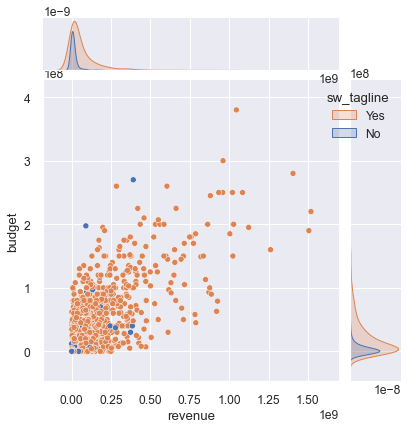

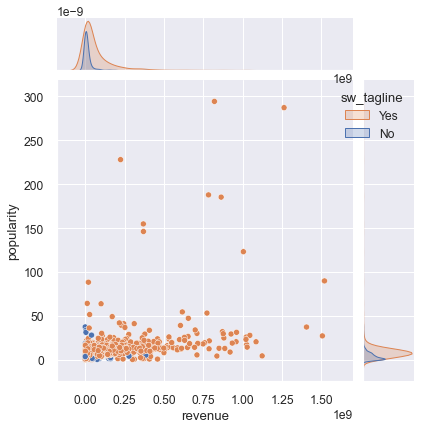

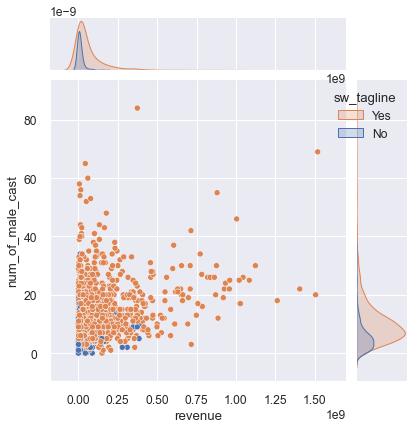

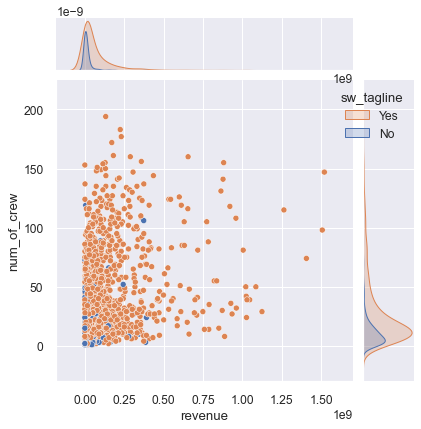

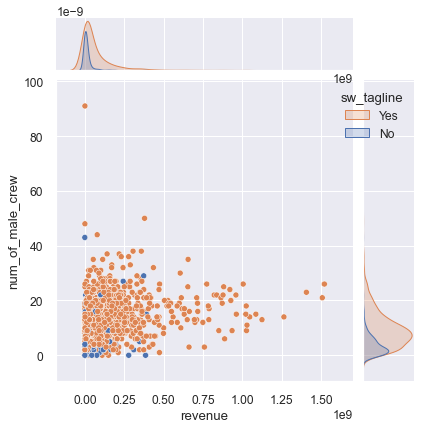

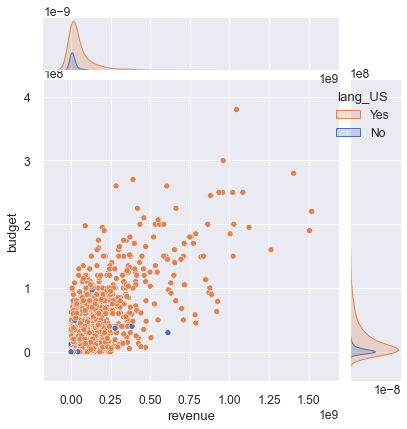

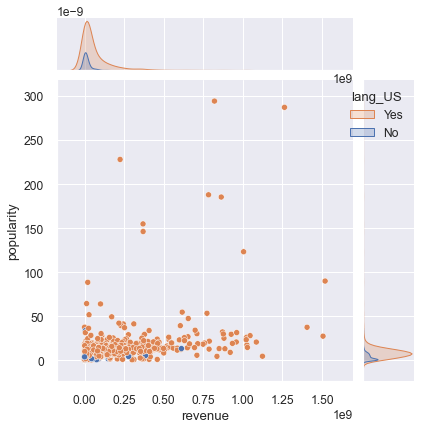

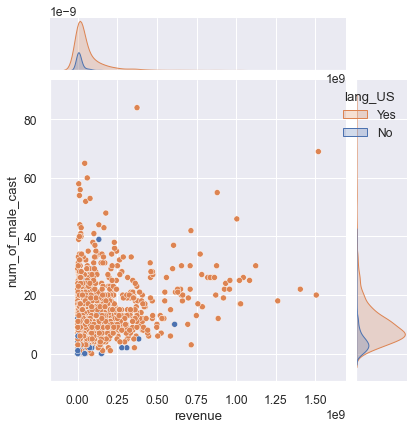

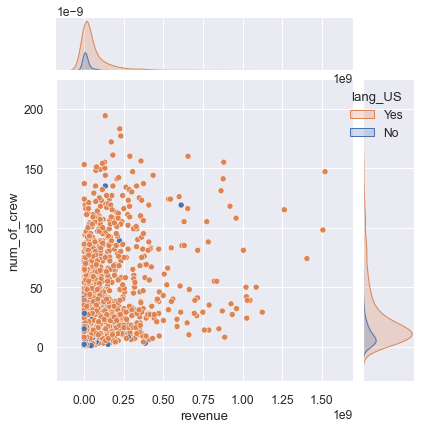

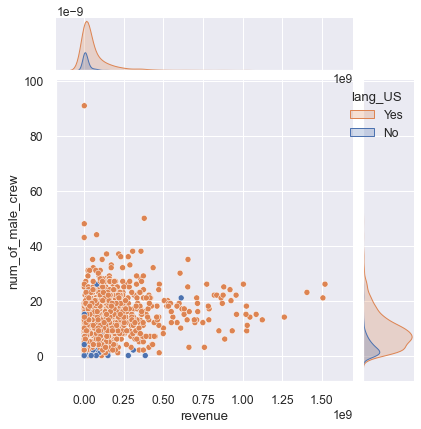

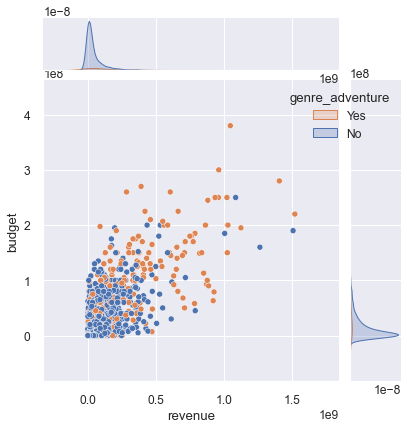

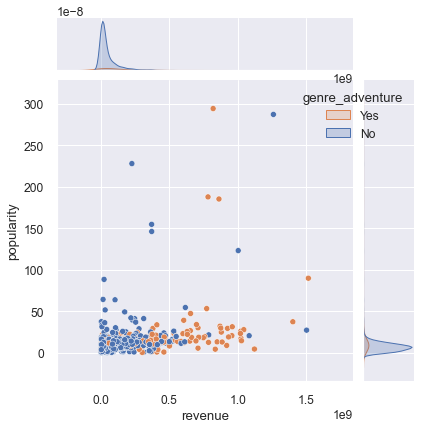

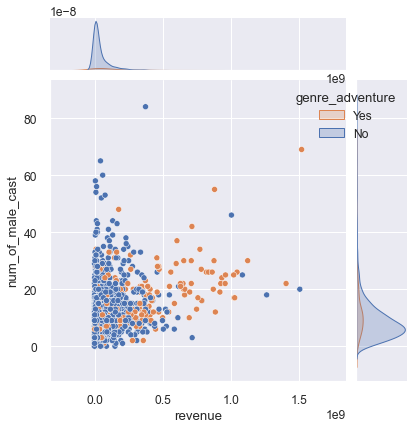

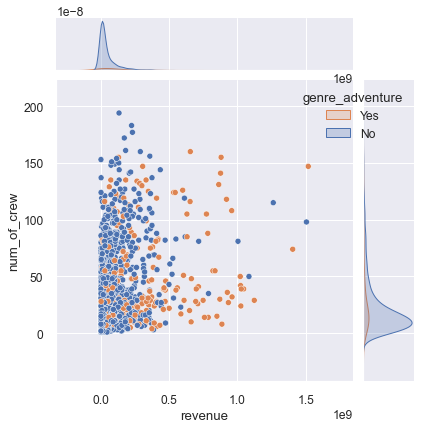

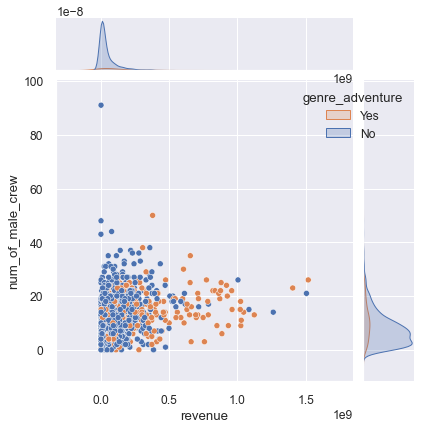

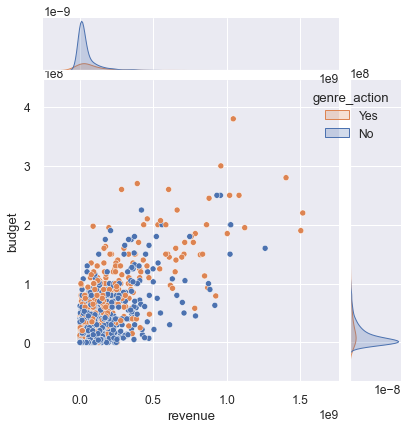

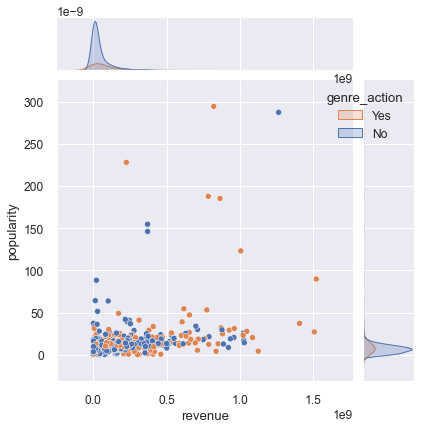

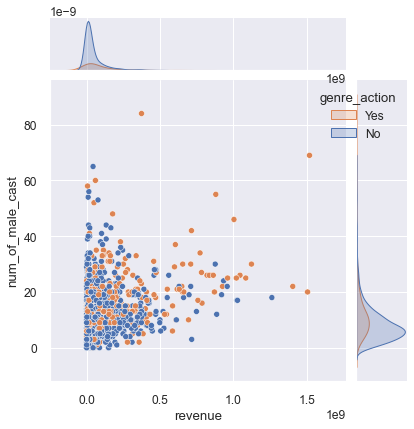

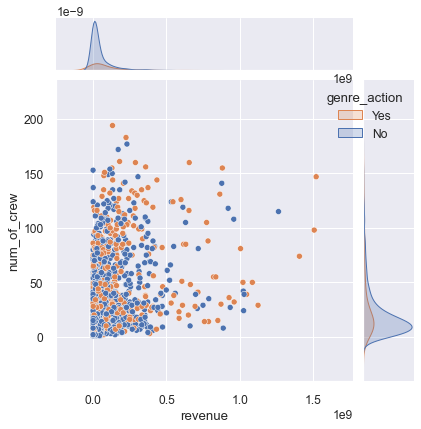

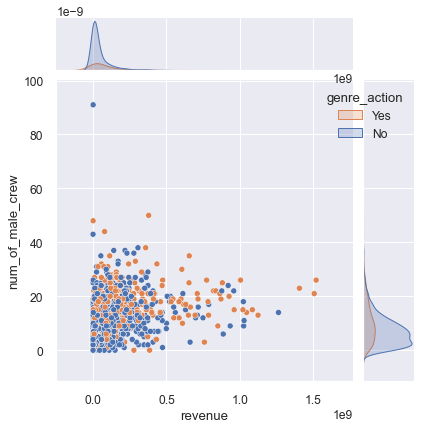

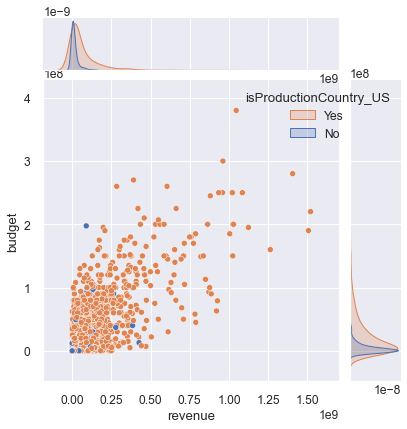

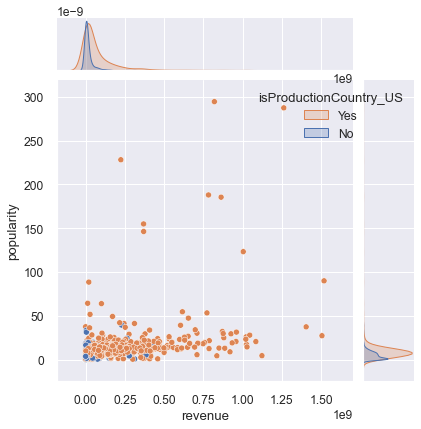

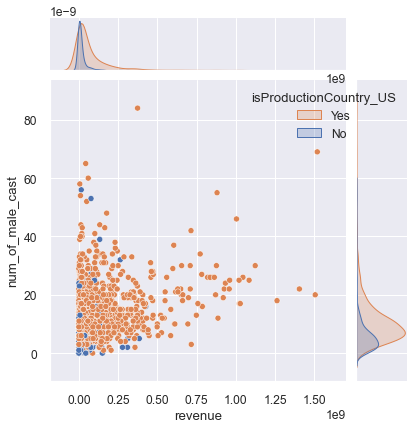

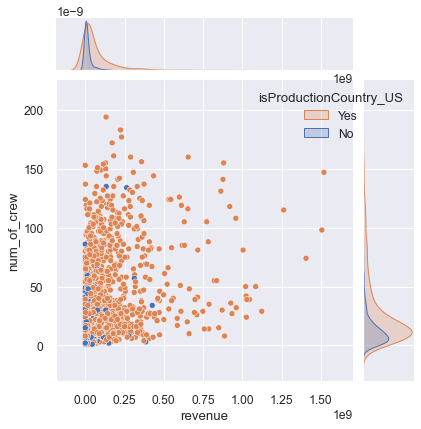

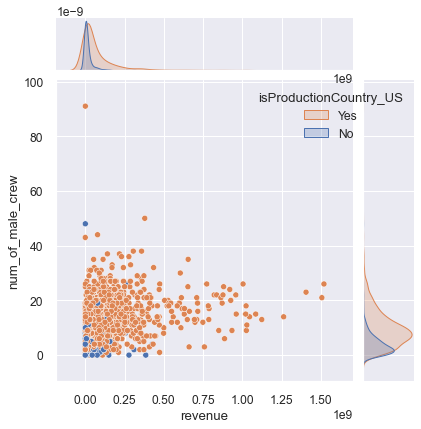

In [27]:
sns.set(font_scale = 1.1)
for i in df_dummy:
    if i != 'revenue' and i in avona_dummy.head().index:
        for j in df_num:
            if j in corr_num.head().index:
                sns.jointplot(x = 'revenue', y = j, hue=i, data = df, legend=False)
                plt.legend(title=i, loc='upper right', labels=['Yes', 'No'])
plt.show()

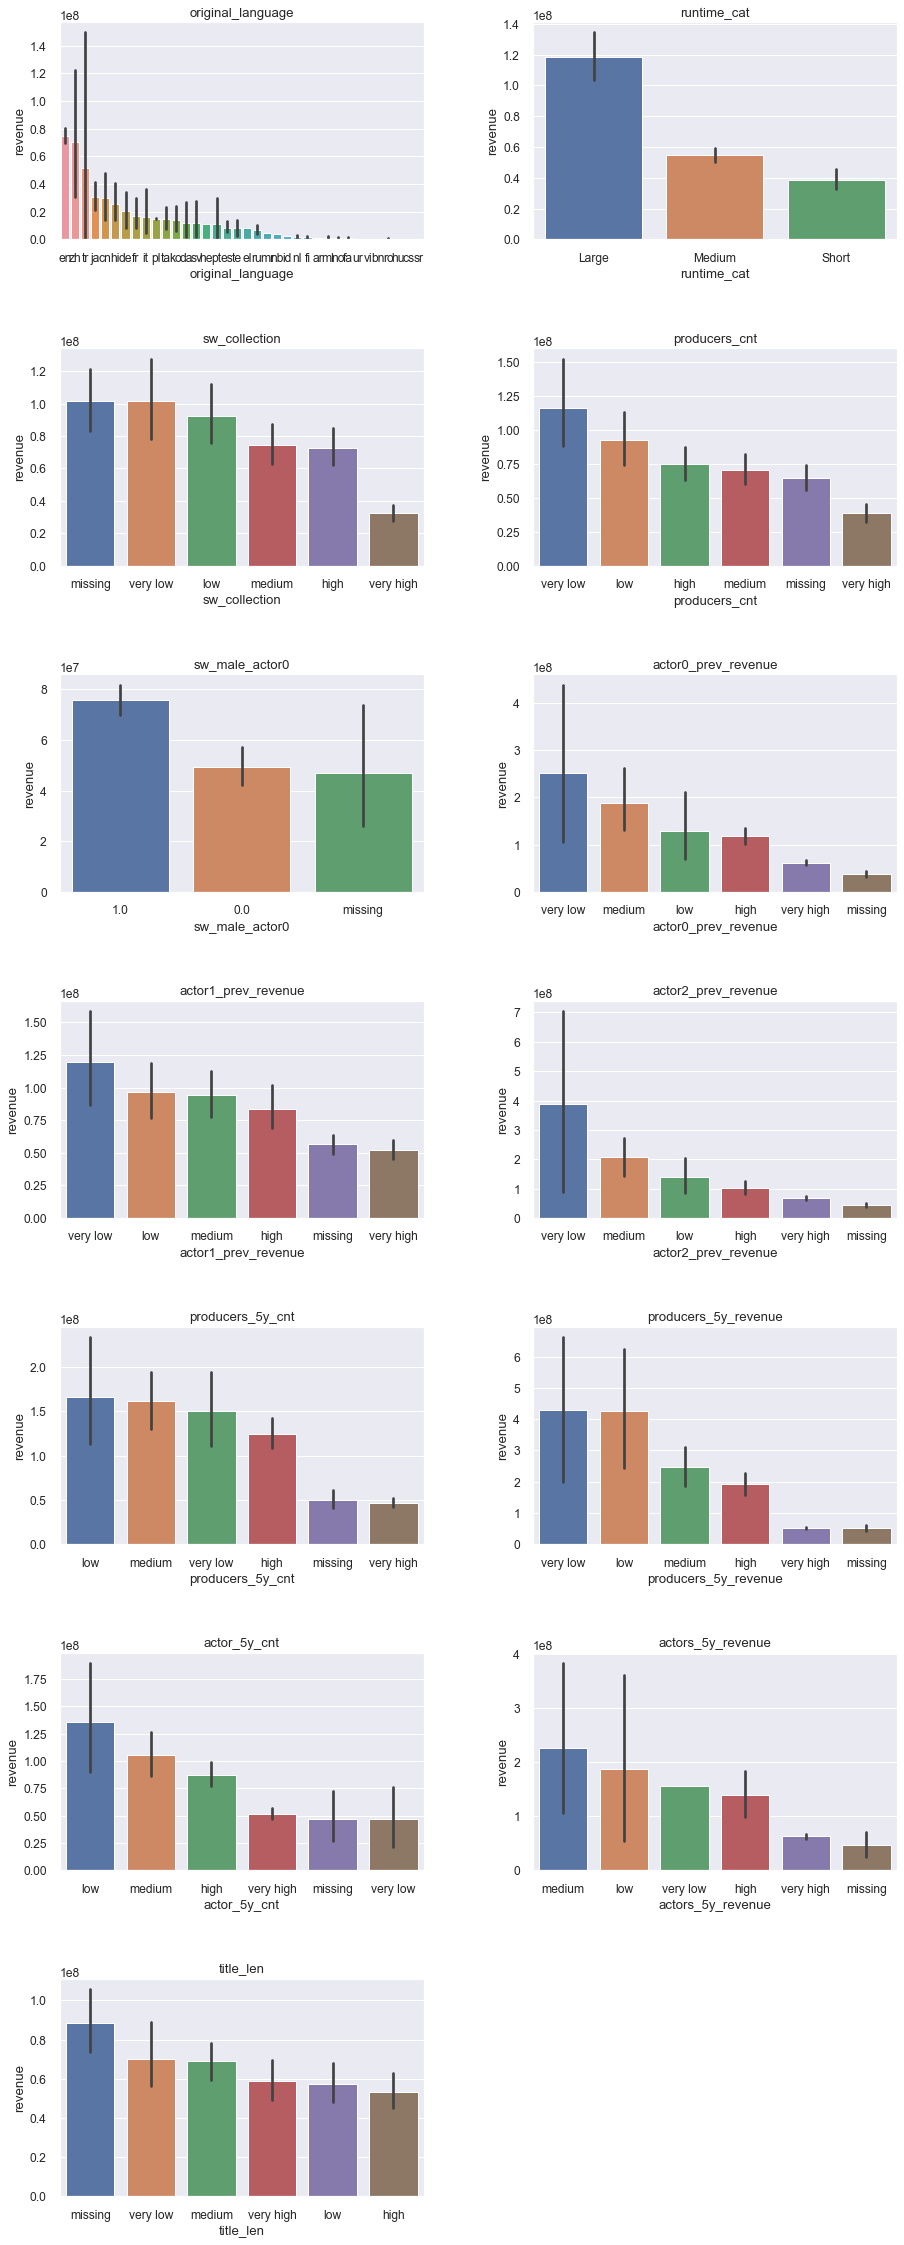

In [28]:
fig = plt.figure(figsize=(15,40))
c = 1
for i in df_categorical:
    if i != 'revenue' and i != 'release_date':
        plot_order = df_categorical.groupby(i)['revenue'].mean().sort_values(ascending=False).index.values
        plt.subplot(7, 2, c)
        plt.title('{}'.format(i))
        plt.xlabel(i)
        sns.barplot(x=i, y='revenue', data=df_categorical, order=plot_order)
        c = c + 1
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
plt.show()

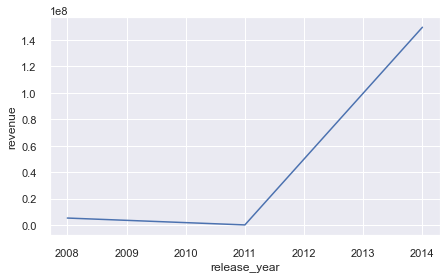

In [29]:
turkish_movie = df[df['original_language']=='tr']
fig = plt.figure(figsize=(7,4))
sns.set(font_scale = 1)
sns.lineplot(data=turkish_movie, x="release_year", y="revenue");

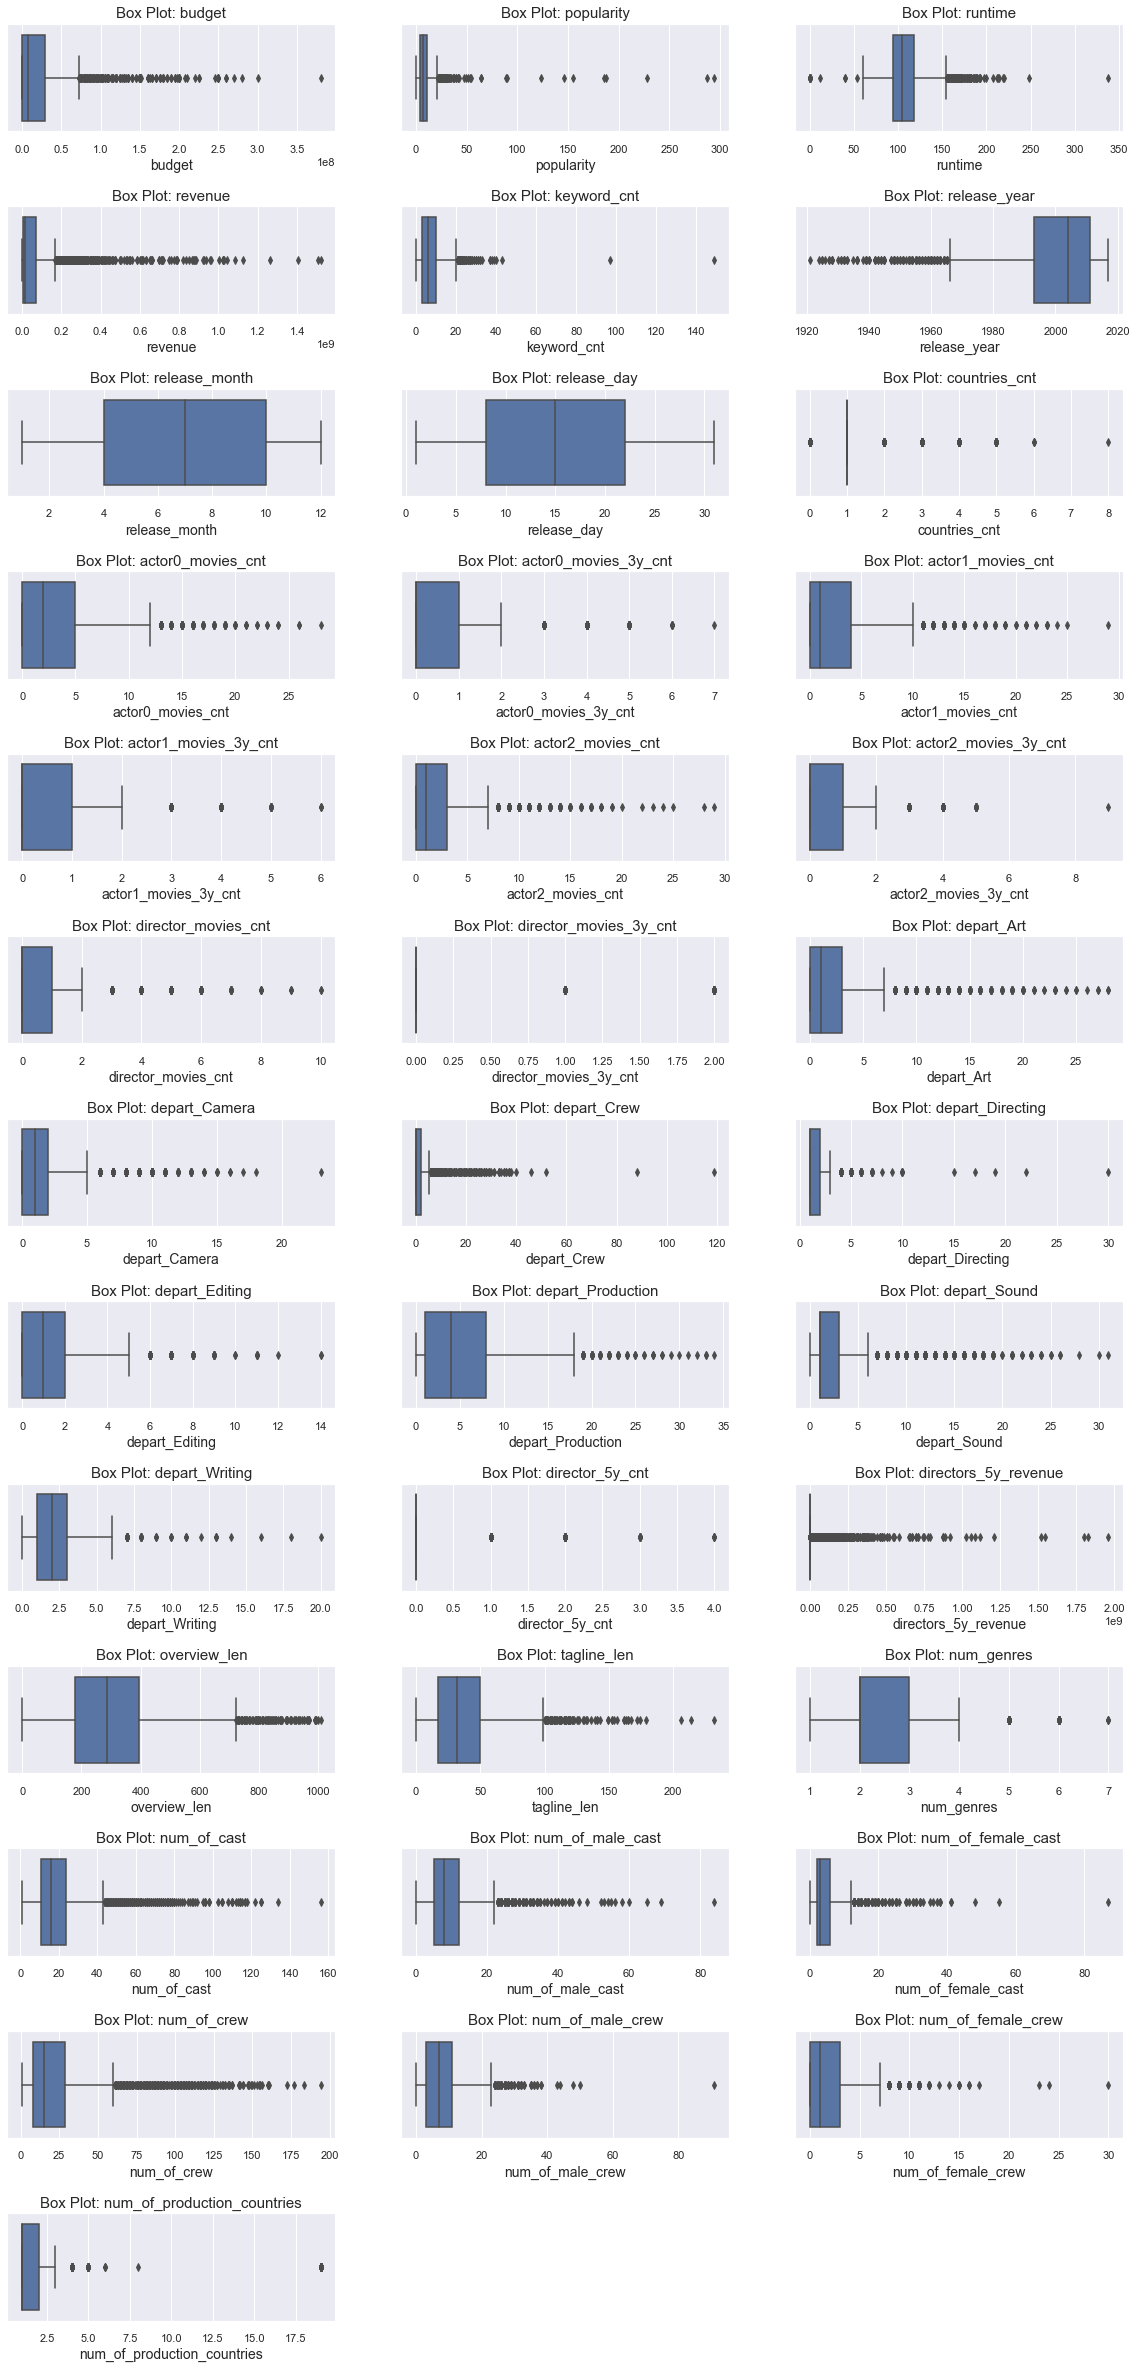

In [30]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'reveune':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)
        
outliers_boxplot(df_num)

For the original outliers boxplots:

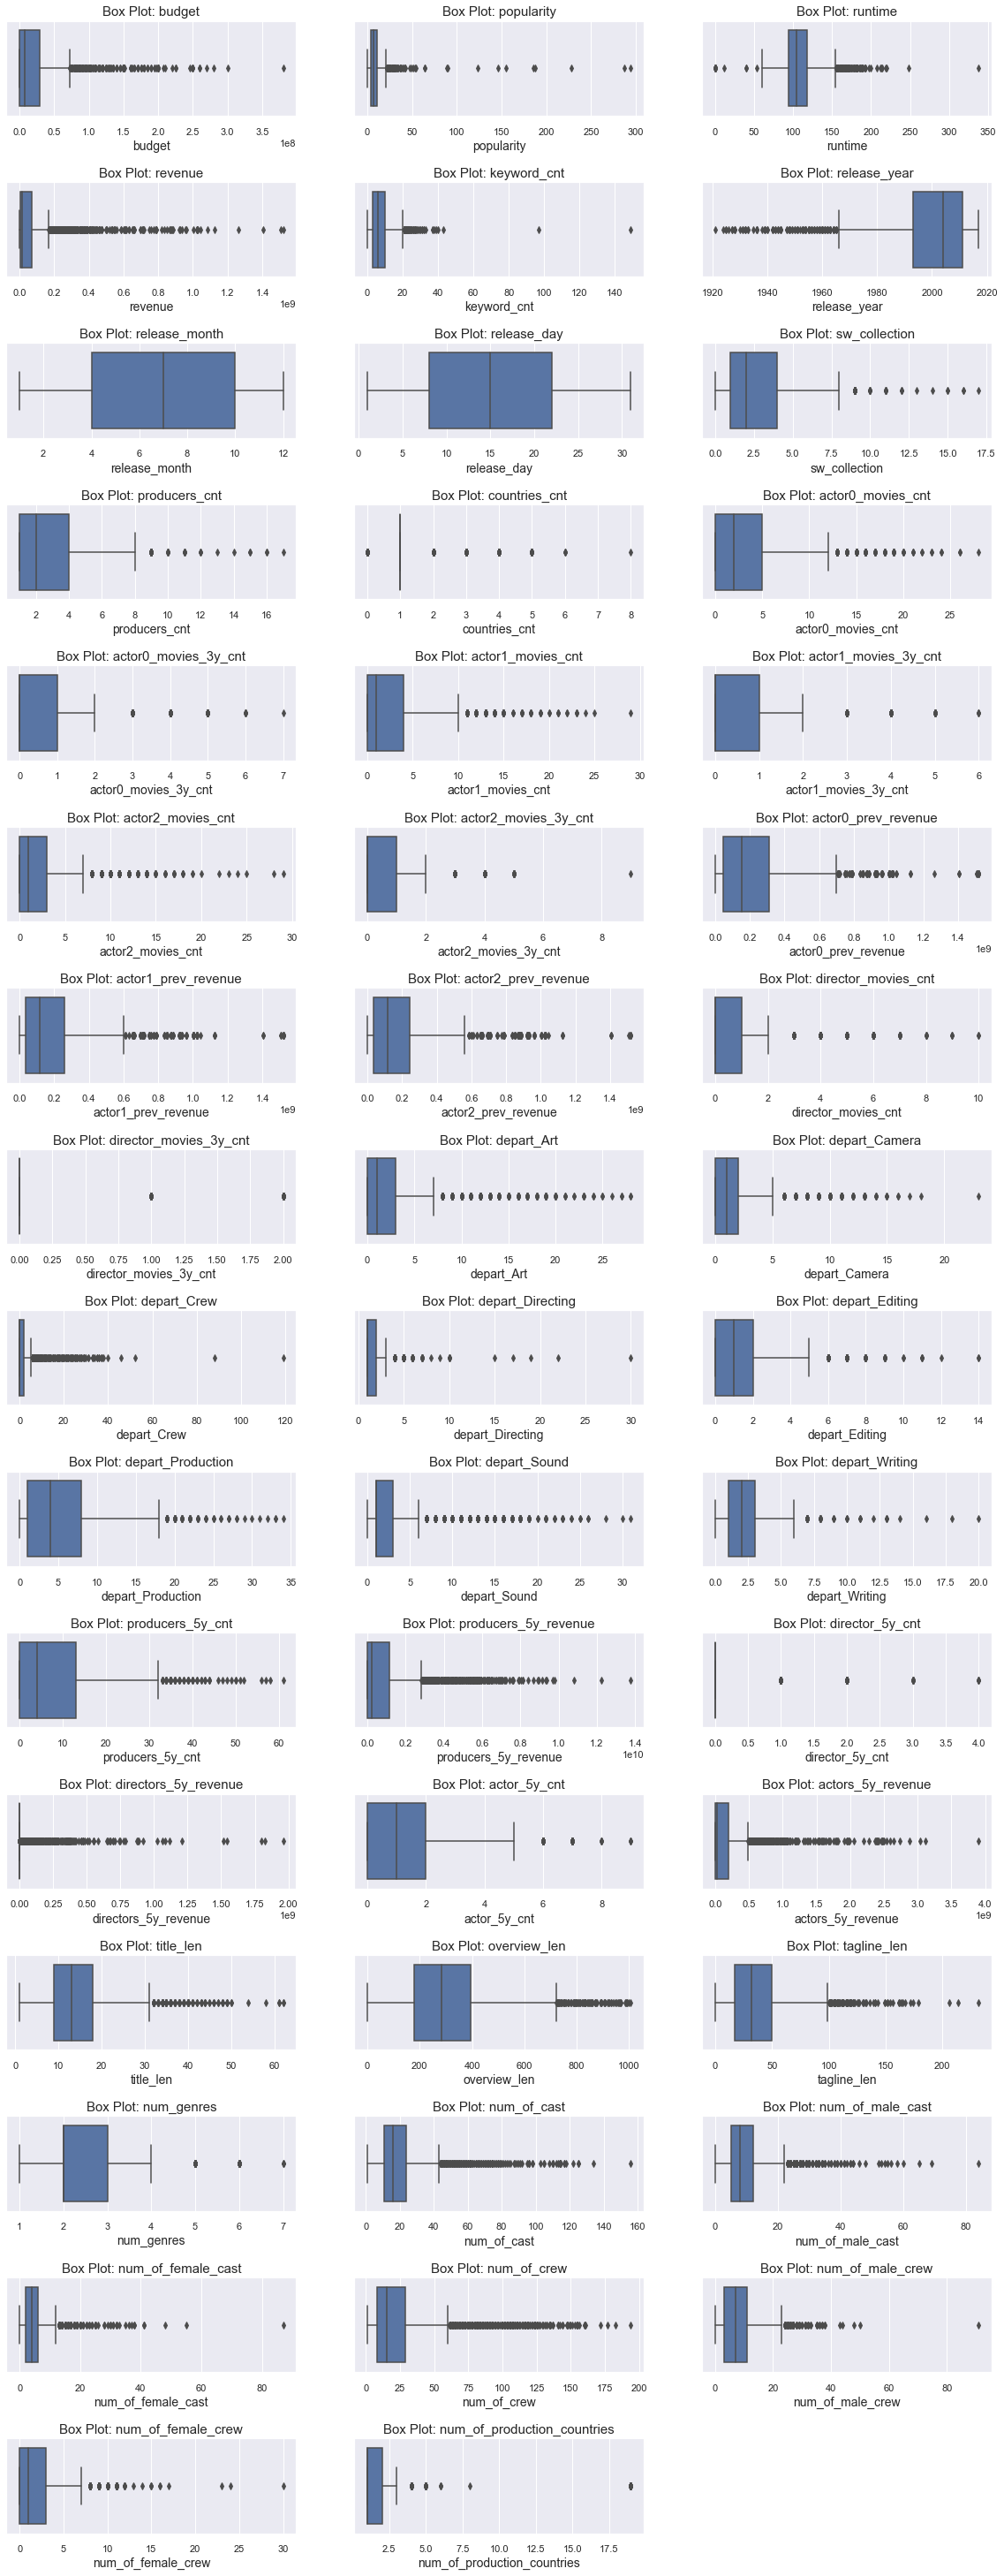

In [33]:
from IPython.display import Image, display
display(Image(filename='BOXPLOTS.png'))

### It was actually fun investigating the data, look for interesting things hiding in the data, I even tried

### regression models and metrics that we've learned to test the data:

In [32]:
models_list = pd.read_csv('models_list.csv', index_col=[0])
models_list.sort_values('RMSLE')

,model,MSE,RMSE,MAE,MSLE,RMSLE
1,Decision Tree,0.098998,0.314640,0.150791,0.005334,0.073034
2,RandomForest,0.120994,0.347842,0.228212,0.006967,0.083471
4,GBM,0.584494,0.764522,0.516572,0.021861,0.147854
0,Linear Regression,0.918249,0.958253,0.646659,0.032469,0.180192
5,SVM,0.931274,0.965025,0.599304,0.034021,0.184447
3,ADABoost,1.253960,1.119804,0.881184,0.034498,0.185736


# END